In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # magic 커맨드 설정 없이 바로 그래프 그릴 수 있도록 설정

__하이퍼파라미터__ 만 조정했을 때와 __EDA 처리__ 를 진행한 데이터 중 어떤 처리가 __손실함수를 낮추는데 더 critical한 기여__ 를 하는지 알아봄.<br>
* 본 파일에는 "하이퍼파라미터만 조정"했을 때의 데이터가, 
* 회고란에는 "EDA 처리를 한 데이터"가 있음.

## step1_데이터 불러오기

In [2]:
train_data_path = join('./data', 'train.csv')
test_data_path = join('./data', 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.shape, test.shape

((15035, 21), (6468, 20))

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


##  step2 데이터 전처리

__train 데이터에서 "date" 데이터 전처리__

In [4]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


__y 변수에 price 값 저장, train데이터에서 price컬럼 빼기__

In [5]:
y = train['price']
del train['price']

y.head(), y.shape

(0    221900.0
 1    180000.0
 2    510000.0
 3    257500.0
 4    291850.0
 Name: price, dtype: float64,
 (15035,))

In [6]:
train.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

__train 데이터에서 "id" 컬럼 빼기__


In [7]:
del train['id']
train.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

__test 데이터도 같은 과정 반복(test는 "price"컬럼 없어서 y 지정 x)__

In [8]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [9]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
#나중에 예측 결과 제출시 "id"값이 필요하므로 sub_id에 "id"컬럼 저장하고 지우기
test_id = test['id']
del test['id']
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [10]:
test.head(3)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930


In [11]:
test_id

0       15035
1       15036
2       15037
3       15038
4       15039
        ...  
6463    21498
6464    21499
6465    21500
6466    21501
6467    21502
Name: id, Length: 6468, dtype: int64

__타겟 데이터 y 확인 및 분포도 시각화__

In [12]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

<Axes: xlabel='price', ylabel='Density'>

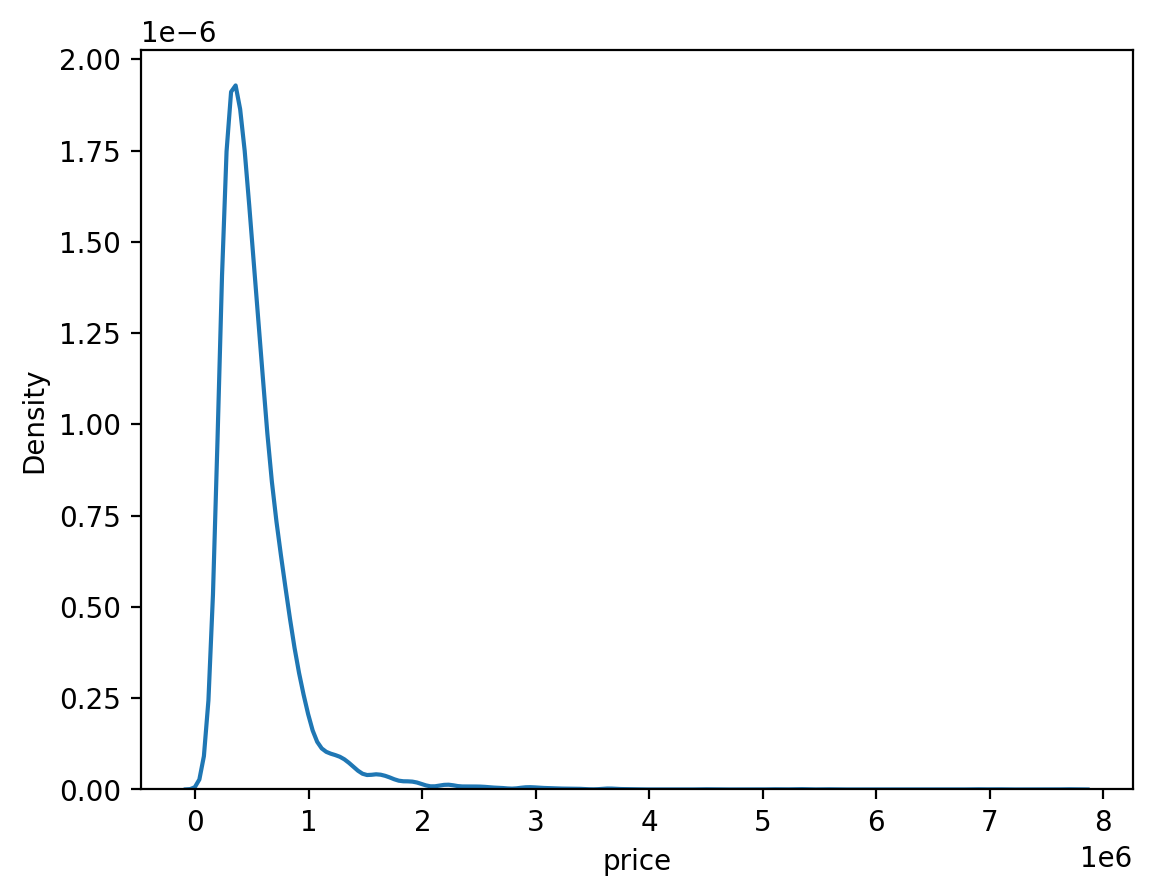

In [13]:
sns.kdeplot(y)

타겟 데이터의 경우 정규 분포를 따르지 않고, 분산 또한 매우 큼. 

__치우친 데이터 로그변환으로 재분산__
* 모델이 값을 예측한 후에 다시 np.expm1()로 되돌려줘야함
* np.log1p()와 다르게 각 원소x마다 exp(x)-1값을 반환해줌

In [14]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

<Axes: xlabel='price', ylabel='Density'>

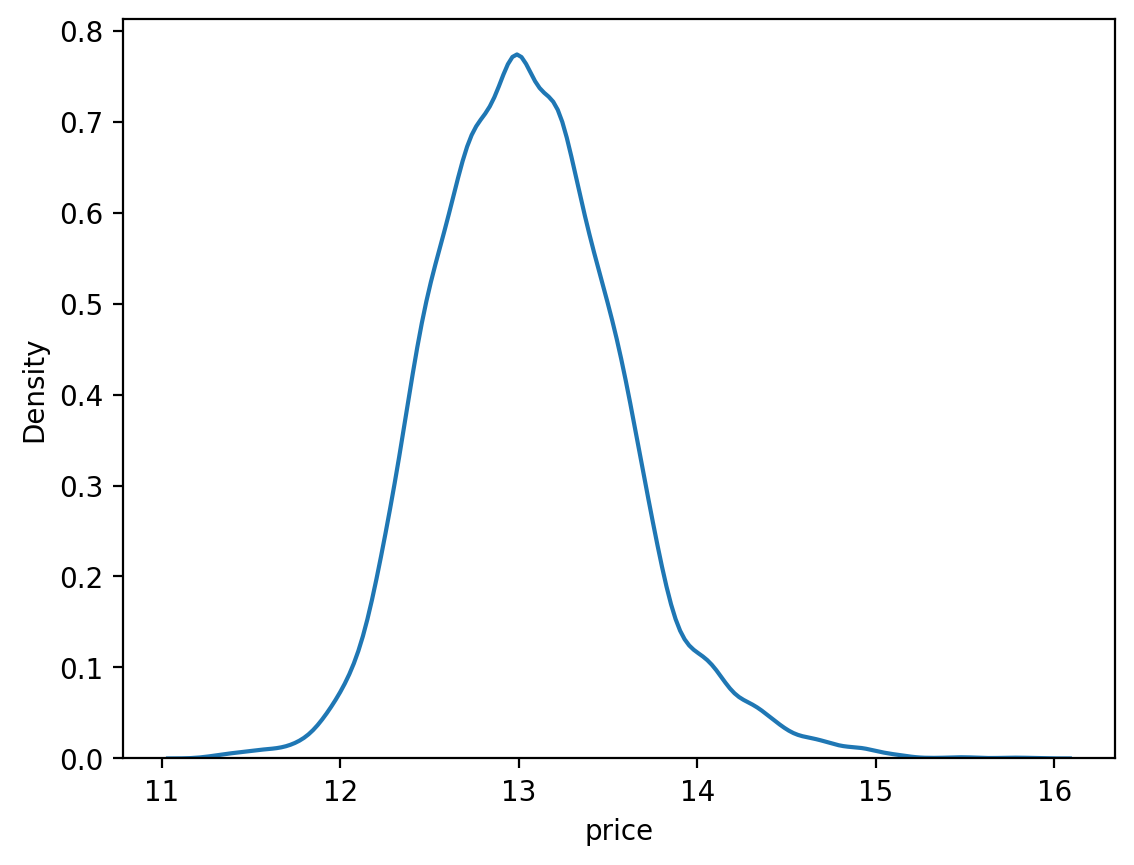

In [15]:
sns.kdeplot(y)

log를 취해줌으로써 기존보다 더 정규성을 갖는 것을 확인할 수 있음.

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int32  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

__모두 실수, 정수 자료형이므로 문제없이 모델학습에 활용 가능__

### [변수 자료 시각화는 링크 통해 확인, 해당 파일의 step1이 시각화에 해당합니다](https://github.com/LubyJ/LubyJ/blob/master/EP03_Feature%20data%20visualization%20and%20EDA.ipynb)

## step3 모델 튜닝_RMSE계산

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

**주의** y_test, y_pred는 위에서 로그변환된 값이기 때문에 원래 데이터의 단위에 맞게 np.expm1()을 추가해 되돌려야 함.

In [18]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [19]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [20]:
random_state=2020 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

각 모델의 이름 얻는법

In [21]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [22]:
xgboost.__class__.__name__

'XGBRegressor'

In [23]:
lightgbm.__class__.__name__

'LGBMRegressor'

In [24]:
rdforest.__class__.__name__

'RandomForestRegressor'

이름에 접근할 수 있다면 for 문 안에서 각 모델별로 학습 및 예측 가능함

In [25]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__
    
    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 112334.52117822798,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125367.2973747959}

위 과정을 "get_scores(models, train, y)" 함수로 만들어보기

In [26]:
def get_scores(models, train, y):
    df = {}
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df
get_scores(models, train, y)    

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125367.297375
XGBRegressor,112334.521178
LGBMRegressor,111920.367359


## step4 하이퍼파라미터 튜닝_그리드 탐색

In [27]:
from sklearn.model_selection import GridSearchCV

1. 그리드 탐색
    - 사람이 먼저 탐색할 하이퍼파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색.
    - 특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리.
    - 최적의 조합을 놓칠 수 있음.<br>
<br>
2. 랜덤 탐색
    - 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법
    - 랜덤 탐색이기 때문에 최적의 조합을 찾을 수 있는 가능성이 열려있음.
    - 가능성 또한 랜덤성에 의존해 언제나 최적을 찾는단 보장은 없음

__1__ "param_grid"에 탐색할 xgboost관련 하이퍼 파라미터 넣어서 준비

In [28]:
param_grid = {'n_estimators': [50, 100], 'max_depth' : [1, 10],}

__2__ 모델 준비

In [29]:
model = LGBMRegressor(random_state=random_state)

__3__ model, param_grid, 다른 여러 인자 넣어서 GridSearchCV 수행

* param_grid : 탐색할 파라미터 종류(딕셔너리로 입력)
* scoring : 모델의 성능을 평가할 지표
* cv : cross validation 수행하기 위해 train 데이터셋을 나누는 조각수
* verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양
* n_jobs : 그리드 탐색 중 사용할 CPU 개수

In [30]:
grid_model = GridSearchCV(model, param_grid=param_grid,
                         scoring='neg_mean_squared_error',
                         cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

__out에 출력된 "totalling 20"의 의미__
 - param_grid에 n_estimator 2개, max_depth 2가지 넣었으므로 가능한 조합은 2 x 2 = 4가지. cv를 5번 진행하도록 설정했으므로 총 20번의 fit 과정을 진행함.
 - 각 조합에 대해 5번을 진행해서 펻균을 취하는게 일반화 오차를 추정하는 데에 더 신뢰도가 높음

__실험 결과는 "grid_model.cv_results\_" 안에 저장됨__

In [31]:
grid_model.cv_results_

{'mean_fit_time': array([0.05787954, 0.0832315 , 0.16945376, 0.25029202]),
 'std_fit_time': array([0.00323358, 0.0039195 , 0.00605604, 0.0035256 ]),
 'mean_score_time': array([0.00480103, 0.00640182, 0.00661011, 0.01295447]),
 'std_score_time': array([0.00392003, 0.00320091, 0.00280223, 0.00190773]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

__어떤 파라미터 조합일 때 점수가 어떻게 나오는지를 확인하고 싶은것이므로 위 데이터에서 필요한 정보만 빼서 보기__

1. 파라미터 조합 꺼내보기 : "params"에 있음

In [32]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

2. 테스트 점수 꺼내보기 : "mean_test_score"에 있음

__score 값이 음수인 이유__
* GridSearchCV로 grid_model 초기화할 때, scoring인자에 'neg_mean_squared_error' 즉, MSE에 음수에 취한 값을 입력했기 때문
* scoring인자에 넣어주는 값은 어떤 문제를 해결하느냐에 따라 크게 3종류로 나뉘며(classification, Clustering, Regression) 각 범주에 해당하는 scoring인자는 [여기서](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) 찾아볼 수 있음.

In [33]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

3. dataframe으로 만들기

In [34]:
hyper = pd.DataFrame(params)
hyper

,max_depth,n_estimators
0,1,50
1,1,100
2,10,50
3,10,100


In [35]:
hyper['score'] = score

In [36]:
hyper

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


RMSE 컬럼 추가하기

In [37]:
hyper['RMSE'] = np.sqrt(-1*hyper['score'])
hyper

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


__주의__
* 위의 RMSE값은 그리드 탐색시 np.expm1()함수로 되돌리는 과정 없이 log변환을 한 price 값을 그대로 사용했기 대문에 수치가 매우 작음.
* 즉, 위 값은 RMSE가 아니라 Root Mean Squared Log Error(RMSLE)임.
* 이에 맞게 컬럼 이름 바꿔주기

In [38]:
hyper = hyper.rename(columns={'RMSE': 'RMSLE'})
hyper

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


__RMSE 낮은 순으로 정렬__

In [39]:
hyper = hyper.sort_values('RMSLE')
hyper

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


__그리드 탐색 수행 및 결과 정리 함수 생성__

In [40]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=verbose, n_jobs=n_jobs)
    
    grid_model.fit(train, y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    hyper = pd.DataFrame(params)
    hyper['score'] = score

    hyper['RMSLE'] = np.sqrt(-1 * hyper['score'])
    hyper = hyper.sort_values('RMSLE')


    return hyper

In [41]:
param_grid ={'n_estimators': [50, 100], 'max_depth': [1, 10], }
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y , param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


__위 결과로부터 가장 좋은 하이퍼파라미터 조합은 max_dapth=10, n_estimators=100 임을 알 수 있음__

<span style="color:red"> * LGBMRegressor, XGBRegressor, RandomForestRegressor , GradientBoostingRegressor 모델에 대해 하이퍼 파라미터를 튜닝하고 그리드 탐색을 통해 최적의 조합을 도출함<br> * 도출된 하이퍼파라미터는 step 5의 Average Blending 모델 구현 시 적용함</span>

1. [LGBMRegressor](https://github.com/LubyJ/LubyJ/blob/master/EP03_hyper%20parameter%20tuning1_LGBMRegressor.ipynb)
2. [XGBRegressor](https://github.com/LubyJ/LubyJ/blob/master/EP03_hyper%20parameter%20tuning2_xgboost.ipynb)
3. [RandomForestRegressor](https://github.com/LubyJ/LubyJ/blob/master/EP03_hyper%20parameter%20tuning3_RandomForestRegressor.ipynb)
4. [GradientBoostingRegressor](https://github.com/LubyJ/LubyJ/blob/master/EP03_hyper%20parameter%20tuning4_GradientBoostingRegressor(gboost).ipynb)

## step5 위에서 구한 파라미터로 구성된 모델 준비 및 학습 후 예측 결과 생성

보팅 적용을 위한 개별 모델 준비(위에서 도출한 파라미터로 구성)

__Average Blending__
* 위에서 도출한 하이퍼파라미터로 구성된 개별 모델 준비
* 여러가지 모델의 산술 평균을 통해 Blending 모델 구현

In [42]:
random_state=2020
lightgbm = LGBMRegressor(n_estimators=350, max_depth=10, learning_rate=0.05,
             boosting_type='gbdt', subsample=1.0, 
             feature_fraction=0.7, random_state=random_state)
xgboost = xgb.XGBRegressor(n_estimators=150, max_depth=5, random_state=random_state)
rdforest = RandomForestRegressor(n_estimators=100, max_depth=50, random_state=random_state)
gboost = GradientBoostingRegressor(n_estimators=200, max_depth=8, 
            learning_rate=0.1, subsample=1.0, random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}, {'model' : rdforest, 'name':'RandomForest'}]

__Cross Validation__<br>
교차 검증을 통한 모델 성능 평가

In [43]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019, shuffle=True).get_n_splits(train.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], train.values, y)), 
                                             kf=kfold))

In [44]:
get_cv_score(models)

Model GradientBoosting CV score : 0.9002
Model XGBoost CV score : 0.8983
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
Model LightGBM CV score : 0.9072
Model RandomForest CV score : 0.8852


__Average Blending()함수 구현__

In [45]:
def AverageBlending(models, train, y, test):
    for m in models:
        m['model'].fit(train.values, y)
        
    predictions = np.column_stack([
        m['model'].predict(test.values) for m in models])
    
    return np.mean(predictions, axis=1)

In [46]:
y_pred = AverageBlending(models, train, y, test)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7


In [47]:
y_pred

array([13.13320285, 13.10018371, 14.1295175 , ..., 13.05688395,
       12.67352632, 13.00575411])

**주의** y_test, y_pred는 위에서 로그변환된 값이기 때문에 원래 데이터의 단위에 맞게 np.expm1()을 추가해 되돌려야 함.

In [48]:
y_transformed =  np.expm1(y_pred)
y_transformed

array([ 505448.21585009,  489031.24628069, 1368898.23762687, ...,
        468308.15993588,  319184.05466813,  444965.42689808])

"id"와 "price" 두 열로 구성된 dataframe 생성

In [49]:
result = pd.DataFrame(data={'id': test_id, 'price': y_transformed})
result.head()


,id,price
0,15035,5.054482e+05
1,15036,4.890312e+05
2,15037,1.368898e+06
3,15038,3.070751e+05
4,15039,3.290015e+05


## step6 작업 제출

In [50]:
my_submission_path = join('./data', 'submission2.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

./data\submission2.csv


# 회고

1. hyper parameter 조정 후 훈련 데이터 셋으로 4개 모델(lightgbm, xgboost, gboost, reforest)을 학습시키고, Average blending 모델을 이용해 교차 검증 시킨 결과 R<sup>2</sup>값이 향상됨을 확인함<br>
* Model GradientBoosting CV score : 0.8597 ==> 0.8967
* Model XGBoost CV score : 0.8861 ==> 0.8948
* Model LightGBM CV score : 0.8819 ==> 0.9050
* Model RandomForest CV score : x ==> 0.8842

2. Kaggle에 제출 및 점수 확인
<img src=https://user-images.githubusercontent.com/127171630/227271609-9ae9c60a-6865-47c1-b6d5-c3417feb15e7.png>

3. 데이터 시각화 및 EDA 처리를 통한 RMSE 변화 추이 확인
* __[링크 확인!](https://github.com/LubyJ/LubyJ/blob/master/EP03_Feature%20data%20visualization%20and%20EDA.ipynb) 해당 파일의 step2부터 보시면 됩니다!__
* 결론은 어떤 전처리를 하든, EDA로 새로운 Feature 조합을 만들어 내든 아무처리도 하지 않은 __원본 데이터보다 RMSE 값이 높게 나옴__.
* trial error 종류
    - 이상치 15개 삭제
    - Feature 새로 조합하기 전 데이터셋에서 price와 상관관계가 높은 top 10 feature만 가지고 테스트
    - Feature 새로 조합한 후 데이터셋에서 price와 상관관계가 높은 top 10 feature만 가지고 테스트
    - min-max scaling 정규화 (이상치만 삭제한 데이터 이용)
    - min-max scaling 정규화2 (Feature 새로 조합 전 데이터셋의 top10 feature 반영)
    - min-max scaling 정규화3 (Feature 새로 조합 후 데이터셋의 top10 feature 반영)

4. 정규화를 진행할 때, 카테고리형 feature 데이터와 연속적 실수값을 갖는 feature 데이터를 함께 정규화를 시켜도 되는지 의문임
    * 집값과 높은 상관관계를 갖는 feature는 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms' 'lat' 'bedrooms' 'floors' 'view'이고, 이 중 스케일이 큰 feature는 'sqft_living' 'sqft_living15' 'sqft_above'임.
    * 데이터를 학습할 때, 스케일이 큰 feature의 중요도가 과중되는 문제로 인해 정규화를 진행하는데, 상관관계가 높은 feature 중 다수가 스케일이 큼. 그렇담 굳이 정규화를 할 필요가 없는거 아닐까?
    * 정규화를 안하면 스케일이 작고, 심지어 카테고리형 feature인 'grade', 'bathrooms', 'bedrooms', 'floors', 'view' 항목들은 힘을 못쓰고 묻혀버리는게 아닐까?

# References

[1] [데이터 시각화 및 EDA](https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12)<br>
[2] [LightGBM hyperparameter tuning](https://smecsm.tistory.com/133)<br>
[3] [LightGBM hyperparameter tuning2](https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5)<br>
[4] [xgboost hyperparameter tuning](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook)<br>
[5] [randomforestRegressor hyperparameter tuning](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)<br>
[6] [gradient boosting hyperparameter tuning](https://www.kaggle.com/code/elyousfiomar/hyperparameter-tuning-gradient-boosting)